# Neural machine translation through sequence-to-sequence model with attention - Part B

Welcome to the seven HDA laboratory! In this notebook, you will use the building blocks you implemented yesterday to build the sequence-to-sequence neural machine translator. You will implement a customized training pipeline and you will finally obtain a network able to translate words from Italian to English!

In this notebook, sections 1, 2, 3 and 4 are already completed with the solutions from Laboratory 6. If you don't remember the structure go through them, otherwise you can directly start from section 5.

This notebook is a revisitation of the one proposed by [TensorFlow](https://www.tensorflow.org/text/tutorials/nmt_with_attention). 
If you want to experiment more, once completed this notebook you can also go through the notebook about [Transformers](https://www.tensorflow.org/text/tutorials/transformer). Prof. Rossi will go through the transformer architecture during the January lessons.  

**In this assignment, you will:**
- Put together the building blocks from Laboratory 6 to create a sequence-to-sequence neural machine translator

**NOTE**
For this lab, we will provide you also with the *.py* files so that you can run the code with a Python IDE. We suggest using a Python IDE instead of Jupyter Notebooks for developing the code for your final project as the debugging would be easier (you can find some suggestions in the how-to document in Moodle).

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
from dataset_utils import *

## Load the dataset
Download the dataset from [here](http://www.manythings.org/anki/) and unzip it in the same folder of the notebook. In this notebook the ita-eng one is chosen but you can select the one you prefer and change the first line below.
The `buff_size` variable is to select a small portion of the dataset for reducing the complexity of the training, you can increase it to obtain a better translator.

In [6]:
path_to_file = pathlib.Path('./ita-eng/ita.txt')
buff_size = 30000
inp, targ = load_data(path_to_file, buff_size)
print(inp[-2])
print(targ[-2])

Quello è un tavolo.
That is a table.


Split the data into training and test sets.

In [7]:
train_len = int(buff_size * 0.8)

inp_train = inp[:train_len]
targ_train = targ[:train_len]

inp_test = inp[train_len:]
targ_test = targ[train_len:]

Create the training and test datasets. Use the function [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create the dataset with ``input`` and ``target`` pairs. Hence, cache the dataset, and apply the shuffling and the baching operations (see Lab 5 for reference).

In [8]:
batch_size = 64

### START CODE HERE ###
dataset_train = tf.data.Dataset.from_tensor_slices((inp_train, targ_train))
cache_file_train = 'dataset_cache_train'
dataset_train = dataset_train.cache(cache_file_train)
dataset_train = dataset_train.shuffle(buff_size)
dataset_train = dataset_train.batch(batch_size)
### END CODE HERE ###

### START CODE HERE ###
dataset_test = tf.data.Dataset.from_tensor_slices((inp_test, targ_test))
cache_file_test = 'dataset_cache_test'
dataset_test = dataset_test.cache(cache_file_test)
dataset_test = dataset_test.shuffle(buff_size)
dataset_test = dataset_test.batch(batch_size)
### END CODE HERE ###

Create a [tf.keras.layers.TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) that you will use in the following to map the text into integer sequences. We use the custom `tf_lower_and_split_punct` in `dataset_utils.py` for the standardization (e.g., remove accents, and put all letters in lowercase...). This operation is needed because we want to use a vocabulary with a limited size.

In [9]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,
                                                         max_tokens=max_vocab_size)
input_text_processor.adapt(inp_train)

output_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,
                                                          max_tokens=max_vocab_size)
output_text_processor.adapt(targ_train)

Run the cell below to have an example of how the preprocessing is working.

In [10]:
example_text = tf.constant('Hi! You\'ve almost done, this is the sixth HDA lab. Oggi è il sesto laboratorio del corso HDA!')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Hi! You've almost done, this is the sixth HDA lab. Oggi è il sesto laboratorio del corso HDA!
[START] hi !  you ' ve almost done ,  this is the sixth hda lab .  oggi e il sesto laboratorio del corso hda ! [END]


## 1 - Encoder
Let's start to create the seq2seq model. 
<center><img src="images/seq2seq.jpg" style="width:50%"></center>
<caption><center> The seq2seq model with attention.<br> </center></caption>

The first block we need to code is the encoder. This block processes the input sequence and encodes it into a code of fixed size.

To create the encoder we define a [custom tf.keras.Layer](https://www.tensorflow.org/guide/keras/custom_layers_and_models) by subclassing the tf.keras.Layer. We will instantiate all the sub-layers that we need for this new layer and combine them to create the new layer. 
Here in the ``init`` method we instantiate all the sub-layers needed to define the encoder. Each layer will be an attribut of the class, i.e., it will be referred to as ``self.attribute_name`` within the class.  
Next, the `call` method creates the layer by combining the sub-layers instantiated above: first the input is forwarded through the embedding sub.layer and the output of the embedding is forwarded through the RNN with GRU sub-layer. 
    
Specifically, through the ``call`` method, the encoder:
1. takes a list of token indices
2. converts each token into an embedding vector using a [layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
3. processes the embeddings sequentially through a [tf.keras.layers.GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) and obtain the output state (`return_state`=True) and the entire sequence of hidden states resulting from the processing of the entire sequence (`return_sequences`=True), use `glorot_uniform` for the initializer
4. returns the processed sequence that will be passed to the attention layer and the internal state stat will serve to initialize the decoder 

In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        """
        This class creates a new custom tf.keras.Layer. This is done by instantiating some attributes and combining them.
        For more info see: https://www.tensorflow.org/guide/keras/custom_layers_and_models
        Here we instantiate all the layers that we need for this model. 
        Next, the `call` method create the layer by combining the ones instantiated here.
        :param input_vocab_size: the size of the vocabulary
        :param embedding_dim: fixed size for the embeddings
        :param enc_units: number of neurons for the encoding
        """
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # Instantiate an embedding layer to convert tokens into vectors
        # see https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
        ### START CODE HERE ###
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)
        ### END CODE HERE ###

        # Instantiate a GRU RNN layer to process those vectors sequentially
        ### START CODE HERE ###
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        ### END CODE HERE ###

    def call(self, tokens, state=None):
        """
        This function create the custom tf.keras.Layer structure by combining the blocks defined in the __init__
        :param tokens: the input tokens
        :param state: the info state for the GRU RNN (if present)
        :return: the outout and the state of the GRU RNN
        """
        ### START CODE HERE ###
        vectors = self.embedding(tokens)
        output, state = self.gru(vectors, initial_state=state)
        ### END CODE HERE ###
        return output, state

Check the correct functioning of the encoder by running the cell below.

In [12]:
embedding_dim = 256
units = 1024

for example_input_batch, example_target_batch in dataset_train.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

# Convert the input text to tokens using the input_text_processor layer 
# that you created above as an instance of tf.keras.layers.TextVectorization
### START CODE HERE ###
example_tokens = input_text_processor(example_input_batch)
### END CODE HERE ###

# Instantiate an object of the Encoder class
### START CODE HERE ###
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
### END CODE HERE ###

# Encode the input sequence using the Encoder object you have just instantiated
### START CODE HERE ###
example_enc_output, example_enc_state = encoder(example_tokens)
### END CODE HERE ###

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

tf.Tensor(
[b'Io spero che lei muoia.' b'Sono pi\xc3\xb9 alto.'
 b'Io sono stato licenziato.' b'Tu hai fallito.' b'Tom mi ha baciato.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I hope you die.' b'I am taller.' b'I got fired.' b"You've failed."
 b'Tom kissed me.'], shape=(5,), dtype=string)
Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 10)
Encoder output, shape (batch, s, units): (64, 10, 1024)
Encoder state, shape (batch, units): (64, 1024)


## 2 - Attention layer
The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an attention vector for each example.
We use the attention layer [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention) that follows the [Bahdanau-style attention](https://arxiv.org/pdf/1409.0473.pdf). 
The query is the decoder state ($\boldsymbol{h}_t$) attending to the sequence while the value is the encoder output ($\bar{\boldsymbol{h}}_s$) being attended to.
The attention weights and the context vector are computed as follows.

$$\large{\rm{score}(\boldsymbol{h}_t, \boldsymbol{\bar{h}}_s) = \rm{tanh}(\boldsymbol{W_1}\boldsymbol{h}_t + \boldsymbol{W_2}\boldsymbol{\bar{h}}_s)}$$

<center><img src="images/attention_equation_1.jpeg" style="width:50%"></center>
<center><img src="images/attention_equation_2.jpeg" style="width:50%"></center>



In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        This class creates a new custom tf.keras.Layer. This is done by instantiating some attributes and combining them.
        For more info see: https://www.tensorflow.org/guide/keras/custom_layers_and_models
        Here we instantiate all the layers that we need for this model. 
        Next, the `call` method create the layer by combining the ones instantiated here.
        :param units: number of units for the Dense layer
        """
        super(BahdanauAttention, self).__init__()
        
        # Instantiate two Dense layers for the query (decoder state) and for the value (decoder output)
        # with 'units' output neurons, use use_bias=False
        ### START CODE HERE (2 lines) ### 
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        ### END CODE HERE ###

        # Instantiate a AdditiveAttention layer
        ### START CODE HERE ###
        self.attention = tf.keras.layers.AdditiveAttention()
        ### END CODE HERE ###

    def call(self, query, value, mask):

        # Pass the query (the decoder state attending to the sequence) through the first dense layer
        ### START CODE HERE ###
        w1_query = self.W1(query)
        ### END CODE HERE ###

        # Pass the value (the sequence of encoder outputs being attended to) through the second dense layer
        ### START CODE HERE ###
        w2_key = self.W2(value)
        ### END CODE HERE ###

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        ### START CODE HERE ###
        context_vector, attention_weights = self.attention(inputs=[w1_query, value, w2_key],
                                                           mask=[query_mask, value_mask],
                                                           return_attention_scores=True)
        ### END CODE HERE ###

        return context_vector, attention_weights

Check the correct functioning of the attention layer by running the cell below.

In [14]:
### START CODE HERE ###
attention_layer = BahdanauAttention(units)
### END CODE HERE ###

# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens, the mask is used to exclude the padding
context_vector, attention_weights = attention_layer(query=example_attention_query,
                                                    value=example_enc_output,
                                                    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 10)


(0.11861671529710292, 0.13179635033011436)

<Figure size 640x480 with 0 Axes>

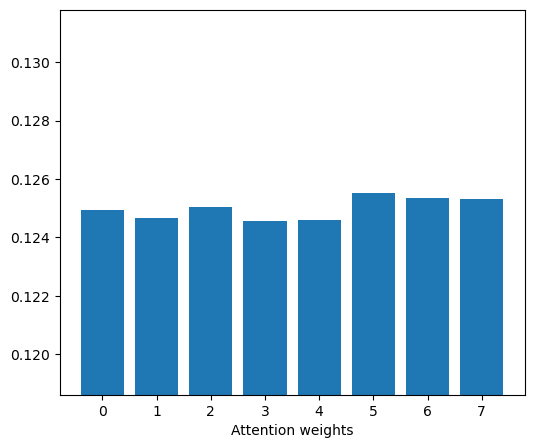

In [15]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(6, 5))
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights')

# zoom in
top = max(plt.ylim())
zoom = 0.85*top
plt.ylim([0.90*top, top])

## 3 - Decoder
The decoder generates the prediction for the next output token starting from the encoder output

1. it uses an RNN to keep track of what it has predicted previously
2. the RNN output is used as a query for the attention layer to attend the encoder's output and produce the context vector
3. the context vector is combined with the RNN output to generate the attention vector using the equation

$$\large{\boldsymbol{a}_t = \rm{tanh}(\boldsymbol{W}_c[\boldsymbol{c}_t; \boldsymbol{h}_t])}~~~~~\rm{[attention~vector]}$$

4. finally, it generates logit predictions for the next token based on the attention vector

In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        """
        This class creates a new custom tf.keras.Layer. This is done by instantiating some variables and combining them.
        For more info see: https://www.tensorflow.org/guide/keras/custom_layers_and_models
        Here we instantiate all the layers that we need for this model. 
        Next, the `call` method create the layer by combining the ones instantiated here.
        :param output_vocab_size:
        :param embedding_dim:
        :param dec_units:
        """
        super(Decoder, self).__init__()
        
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # Instantiate an embedding layer to convet token IDs to vectors
        ### START CODE HERE ###
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)
        ### END CODE HERE ###
        
        # Instantiate an RNN to keep track of what's wii be generated from time to time by the decoder
        ### START CODE HERE ###
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        ### END CODE HERE ###

        # Instantiate a BahdanauAttention layer that will obtain as input the RNN output, i.e., the RNN output
        # will be the query to the attention layer over the encoder's output to produce the context vector
        ### START CODE HERE ###
        self.attention = BahdanauAttention(self.dec_units)
        ### END CODE HERE ###

        # Instantiate a Dense layer to combine the RNN output and the context vector to generate the attention vector
        ### START CODE HERE ###
        self.Wc = tf.keras.layers.Dense(self.dec_units, activation=tf.math.tanh, use_bias=False)
        ### END CODE HERE ###

        # Instantiate a fully connected layer to produce the logits for each output token based on the attention vector
        ### START CODE HERE ###
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        ### END CODE HERE ###

    def call(self, new_tokens, enc_output, mask, state=None):
        # Step 1. Lookup the embeddings
        ### START CODE HERE ###
        vectors = self.embedding(new_tokens)
        ### END CODE HERE ###

        # Step 2. Process one step with the RNN
        ### START CODE HERE ###
        rnn_output, state = self.gru(vectors, initial_state=state)
        ### END CODE HERE ###

        # Step 3. Use the RNN output as the query for the attention over the encoder output
        ### START CODE HERE ###
        context_vector, attention_weights = self.attention(query=rnn_output, value=enc_output, mask=mask)
        ### END CODE HERE ###

        # Step 4. Concatenate the context_vector and rnn_output -- shape: (batch t, value_units + query_units)
        ### START CODE HERE ###
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        ### END CODE HERE ###

        # Step 4. Obtain the attention vector: attention_vector = tanh(Wc@context_and_rnn_output)
        ### START CODE HERE ###
        attention_vector = self.Wc(context_and_rnn_output)
        ### END CODE HERE ###

        # Step 5. Generate logit predictions through the final dense layer
        ### START CODE HERE ###
        logits = self.fc(attention_vector)
        ### END CODE HERE ###

        return logits, attention_weights, state

Check the correct functioning of the decoder layer by running the cell below.

In [17]:
### START CODE HERE ###
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
### END CODE HERE ###
    
# Convert the target sequence using the output_text_processor object you instantiated above
### START CODE HERE ###
example_output_tokens = output_text_processor(example_target_batch)
### END CODE HERE ###

# Collect the "[START]" tokens
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

# Run the decoder
### START CODE HERE ###
dec_logits, dec_attention, dec_state = decoder(first_token, enc_output=example_enc_output, mask=(example_tokens != 0), state = example_enc_state)
### END CODE HERE ###

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

sampled_token = tf.random.categorical(dec_logits[:, 0, :], num_samples=1)
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

logits shape: (batch_size, t, output_vocab_size) (64, 1, 2619)
state shape: (batch_size, dec_units) (64, 1024)


array([['bath'],
       ['horrible'],
       ['boat'],
       ['low'],
       ['stuffed']], dtype='<U12')

## 4 - Loss function
Here we create a custom loss function that will be used during training for computing the gradients to be backpropagated and allow updating the weights. The construction is similar to the one seen for the custom layers above,
[see here for more info](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses).

In [18]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        """
        Here we create a custom loss function. The construction is similar to the one seen for the custom layers above.
        See https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses
        """
        super(MaskedLoss, self).__init__()
        
        self.name = 'masked_loss'
        
        ### START CODE HERE ###
        # Use the correct boolean for the from_logits argument
        # Use reduction='none' as you will compute the reduced sum in the __call__ method
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        ### END CODE HERE ###

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch
        ### START CODE HERE ###
        loss = self.loss(y_true, y_pred)
        ### END CODE HERE ###

        # Mask off the losses on padding
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total (use tf.reduce_sum)
        ### START CODE HERE ###
        return tf.reduce_sum(loss)
        ### END CODE HERE ###

## 5 - Implement the training model
Now we create a new custom model by [subclassing the tf.keras.Model class](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class). The process is similar to the one followed to subclass the tf.keras.Layers and tf.keras.losses.Loss classes above. 

Specifically, the `train_step` method overwrites the built-in `train_step` method of the tf.keras.Model class. 
The `train_step` method is the function called by `fit()` for every batch of data. By overwriting it, we can customize the operations performed during the `fit()` call for our custom TranslatorModelTrain model.
We can then call `fit()` as usual -- and it will be running our own learning algorithm.
For additional info see [this reference](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). Do you remember what you see in Laboratory 2 about the two approaches to train a neural network, i.e., custom training and training with built-in Tensorflow functions? Here you are going to combine the two approaches by still using the built-in-functions while changing their behaviour. (Hint: to complete the following portion of the code it will be useful to take a look at what you implemented in Lab 2 on Section 2.3).

Note that we define the steps to train the model following the **teacher-forcing paradigm**, i.e., the decoder is fed with the correct token at each step regardless of the model predictions at the previous steps. Training the network with the decoder prediction at the previous step would strengthen the model but it takes more time. The teacher-forcing approach is the one usually adopted to train seq2seq networks. 

Here below we use `tf.function` [documentation here](https://www.tensorflow.org/api_docs/python/tf/function) to increase the efficiency of the process, especially during training. You can find a complete explanation [here](https://www.tensorflow.org/guide/function). Note that you can also don't use this decorator and your code remains correct, this is just to give you an hint about more advanced features.

To instantiate Encoder and Decoder entities, use ``input_text_processor.vocabulary_size()`` as the ``input_vocab_size``. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#vocabulary_size) for more information.

In [42]:
class TranslatorModelTrain(tf.keras.Model):
    def __init__(self, embedding_dim, units, input_text_processor, output_text_processor):
        """
        Here we instantiate the encoder and decoder that you created as subclasses of the tf.keras.Layer class
        :param embedding_dim: size of the embeddings
        :param units: number of units in the encoding vector
        :param input_text_processor: processing function for the input
        :param output_text_processor: processing function for the output
        """
        super(TranslatorModelTrain, self).__init__()
        
        ### START CODE HERE ###
        # Instantiate an Encoder and a Decoder
        encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
        ### END CODE HERE ###

        ### START CODE HERE ###
        # Define the attributes of objects belonging to the TranslatorModelTrain class
        # Use the input arguments and the entities you just created
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        ### END CODE HERE ###

    def preprocess(self, input_text, target_text):
        """
        Helper function to preprocess the input
        :param input_text: the input text to be translated
        :param target_text: the correct output translation
        :return: tokens and masks
        """
        # Convert the text to token IDs
        ### START CODE HERE ###
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        ### END CODE HERE ###

        # Convert IDs to masks
        input_mask = input_tokens != 0
        target_mask = target_tokens != 0
        
        return input_tokens, input_mask, target_tokens, target_mask

    def loop_step(self, input_token, target_token, input_mask, enc_output, dec_state):
        """
        Helper function used inside the train_step method
        """
        # Run the decoder for one step (pass the proper arguments to self.decoder)
        ### START CODE HERE ###
        logits, _, dec_state = self.decoder(input_token, enc_output, input_mask, state=dec_state)
        ### END CODE HERE ###

        # Compute the loss using the self.loss
        # Note that self.loss will be set when running the compile function 
        # see here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
        y = target_token
        y_pred = logits
        ### START CODE HERE ###
        step_loss = self.loss(y, y_pred)
        ### END CODE HERE ###

        return step_loss, dec_state
    
    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                                   tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def train_step(self, inputs):
        """
        :param inputs: the input of the Model (a batch)
        :return: the loss on the current batch
        """
        # Train with teacher forcing
        input_text, target_text = inputs
        
        # Use the preprocess function you implemented above to obtain input_tokens, input_mask, target_tokens, target_mask
        ### START CODE HERE ###
        (input_tokens, input_mask, target_tokens, target_mask) = self.preprocess(input_text, target_text)
        ### END CODE HERE ###
        
        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            ### START CODE HERE ###
            enc_output, enc_state = self.encoder(input_tokens)
            ### END CODE HERE ###

            # Initialize the decoder's state to the encoder's final state
            # This only works if the encoder and decoder have the same number of units
            # Initialize the loss to a constant equal to zero (use tf.constant(0.0))
            ### START CODE HERE ###
            dec_state = enc_state
            loss = tf.constant(0.0)
            ### END CODE HERE ###

            ### START CODE HERE ###
            # Create a loop that iterate over the lenght of the target (max_target_length)
            # Uset tf.range to create the array of indices used in the iteration
            for t in tf.range(max_target_length-1):
            ### END CODE HERE ###
                # Pass in two tokens from the target sequence:
                # 1. The current input to the decoder [:, t:t+1] --> teacher-forcing training, i.e., you should take the input from target_tokens
                # 2. The target for the decoder's next prediction [:, t+1:t+2]
                input_token = target_tokens[:, t:t+1]
                target_token = target_tokens[:, t+1:t+2]
                
                # Use the loop_step function implemented above to obtain step_loss and dec_state
                # step_loss is added to the loss (cumulative over sequence)
                # dec_state will be used in the next iteration (continuously updated with the new state)
                ### START CODE HERE ###
                step_loss, dec_state = self.loop_step(input_token, target_token, input_mask, enc_output, dec_state)
                loss = loss + step_loss
                ### END CODE HERE ###

            # Average the loss over all non padding tokens.
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply the optimization step: use self.trainable_variables to obtain the trainable weights, 
        # use tape.gradient to obtain the gradients of the loss with respect to the trainable weights, 
        # apply the optimizer using self.optimizer.apply_gradients
        # Note that as for the self.loss, self.optimizer will be set when running the compile function 
        # see here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
        ### START CODE HERE ###
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        ### END CODE HERE ###

        # Return a dict mapping metric names to current value
        # In our case we set the value of the batch_loss
        return {'batch_loss': average_loss}


Check whether the training step works correctly.

In [50]:
# Create an object of the TranslatorModelTrain class
# Note that we already defined the embedding_dim and units variables in section 1 of the notebook,
# and the input_text_processor and output_text_processor in sections 1 and 3 respectively
### START CODE HERE ###
translator = TranslatorModelTrain(embedding_dim=embedding_dim, units=units, input_text_processor=input_text_processor, output_text_processor=output_text_processor)
### END CODE HERE ###

# Configure the optimizer and the loss using the compile method
### START CODE HERE ###
translator.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    loss=MaskedLoss()
)
### END CODE HERE ###

# Call the train_step function for some steps
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.603959>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.5400906>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.409193>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.042782>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9422283>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9038663>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8446238>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1752794>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1469371>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0870075>}



## 6 - Build and fit the translator model
Let's first create a callback to be used during training to save the batch losses. To do that we sub-class the `tf.keras.callbacks.Callback class`.

In [51]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        super(BatchLogs, self).__init__()
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

Now, instantiate the model for the translator and train it (use the `compile` and `fit` methods). 

In [53]:
# Build the encoder and decoder as done before
### START CODE HERE ###
train_translator = TranslatorModelTrain(embedding_dim=embedding_dim, units=units, input_text_processor=input_text_processor, output_text_processor=output_text_processor)
### END CODE HERE ###

# Configure the optimizer and the loss using the compile method as done before
### START CODE HERE ###
train_translator.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    loss=MaskedLoss()    
)
### END CODE HERE ###
# Create an istance of the BatchLogs class to be used as a callback in the fit method below
batch_loss = BatchLogs('batch_loss')

# Fit the model and save the weights
### START CODE HERE ### (2 lines of code)
#train_translator.fit(dataset_train, batch_size=batch_size, epochs=1, verbose=1)
#train_translator.save_weights('attention_model_myweights')
### END CODE HERE ###

In [54]:
# To load presaved weights uncomment the line below
train_translator.load_weights('attention_model_weights')

Plot the loss.

Text(0, 0.5, 'CE/token')

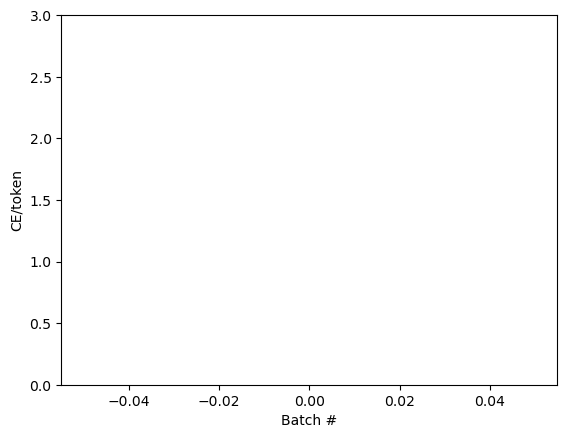

In [55]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

## 7 - Build the translator that uses the trained model to translate an input sentence
Now that the model is trained, here we implement the function thatexecute the full text to text translation.

Overall this is similar to the training loop, except that the input to the decoder at each time step is the last decoder's prediction (no teacher-forcing during the testing phase).

In [65]:
class TranslatorModelInference(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        """
        Here we create a new class by subclassing the tf.Module one. tf.Module id the general class from which all the
        other classes, e.g., tf.keras.Layer, tf.keras.Model, inherits.
        See https://www.tensorflow.org/api_docs/python/tf/Module
        :param encoder: the trained encoder
        :param decoder: the trained decoder
        :param input_text_processor: processing function for the input
        :param output_text_processor: processing function for the output
        """
        super(TranslatorModelInference, self).__init__()
        
        # Define the attributes of objects belonging to the TranslatorModelInference class
        # Use the input arguments
        ### START CODE HERE ###
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        ### END CODE HERE ###

        # Instantiate a StringLookup layers to map integer indices into text using the given vocabulary
        # see https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
        # use vocabulary=output_text_processor.get_vocabulary(), mask_token='', and invert=True
        ### START CODE HERE ###
        self.output_token_string_from_index = tf.keras.layers.StringLookup(vocabulary=output_text_processor.get_vocabulary(), mask_token='', invert=True)
        ### END CODE HERE ###

        # Instantiate a StringLookup layers to map text into integer indices using the given vocabulary
        # see https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup
        # use vocabulary=output_text_processor.get_vocabulary() and mask_token=''
        ### START CODE HERE ###
        index_from_string = tf.keras.layers.StringLookup(vocabulary=output_text_processor.get_vocabulary(), mask_token='', invert=False)
        ### END CODE HERE ###
        
        # The output of the translator network should never generate padding, unknown, or start keys --> mask them
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

    def tokens_to_text(self, result_tokens):
        # Use self.output_token_string_from_index to convert the result_tokens indices into a strings
        ### START CODE HERE ###
        result_text_tokens = self.output_token_string_from_index(result_tokens)
        ### END CODE HERE ###
        result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
        result_text = tf.strings.strip(result_text)
        return result_text

    def sample(self, logits):
        # Set the logits for all masked tokens to -inf, so they are never chosen
        logits = tf.where(self.token_mask, -np.inf, logits)
        logits = tf.squeeze(logits, axis=1)
        # Use tf.random.categorical to obtain the new_tokens based on the logits
        # see https://www.tensorflow.org/api_docs/python/tf/random/categorical
        ### START CODE HERE ###
        new_tokens = tf.random.categorical(logits, num_samples=1)
        ### END CODE HERE ###
        return new_tokens

    def translate(self, input_text, max_length=50):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            # Obtain the logits, attention_weights, and dec_state forwarding the new_tokens through self.decoder
            # use enc_output=enc_output, mask=(input_tokens != 0), state=dec_state
            ### START CODE HERE ###
            logits, attention_weights, dec_state = self.decoder(new_tokens, enc_output=enc_output, mask=(input_tokens != 0), state=dec_state)
            ### END CODE HERE ###
            
            attention.append(attention_weights)

            # Obtain the next token by using the self.sample function 
            ### START CODE HERE ###
            new_tokens = self.sample(logits)
            ### END CODE HERE ###

            # If a sequence produces an `end_token`, set it `done`
            done = done | (new_tokens == self.end_token)
            # Once a sequence is done it only produces 0-padding
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Convert the list of generates token indices to a list of strings
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        attention_stack = tf.concat(attention, axis=1)
        return result_text, attention_stack

Instantiate here below a translator by using the trained encoder and decoder.

In [67]:
# Build the TranslatorModelInference
### START CODE HERE ###
translator = TranslatorModelInference(encoder, decoder, input_text_processor, output_text_processor)
### END CODE HERE ###

C:\Users\Nicola\AppData\Local\Temp\ipykernel_14732\353064367.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


Use the translator to translate sentences! Let's first (first cell here below) try to use the `token_to_text` and the `sample` methods separately and then (next cell) use the complete `translate` method to obtain the English version of an Italian sentence.

In [68]:
example_output_tokens = tf.random.uniform(shape=[5, 2], minval=0, dtype=tf.int64, maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 575],
       [1320],
       [2421],
       [2433],
       [ 552]], dtype=int64)>

apologize tired birds lazy need style solved box sexy pun shuddered recess trips luck unarmed pasta autistic treason kidding drinking way meddling tourist rather yoga obey silly first run try fine beauty brave standing serious row naive
happen skeptical overworked weirdo makes lots hungarian letdown abandon spiders eyes jock
learning complex faithful prudent hi maid elected bring truth stopped bath lungs loved found life admire or horses quiz hit believed dishonest squash honey needed luck finished running memorize sweaty rainy elderly dumb appeared bossy sniffed proud blog objective sugar minute shoe pays miracle grunted go babbling wept average tastes

[1.         1.         0.99999994 1.0000001  1.         1.
 0.99999994 1.0000001  1.         1.         1.         1.
 1.0000001  0.99999994 1.         1.         1.         1.
 1.0000001  1.         1.         1.         1.         0.9999999
 0.9999999  0.9999999  0.9999999  0.9999999  0.9999999  0.9999999
 0.9999999  0.9999999  0.999

c:\Users\Nicola\Documents\university\1_MSc_physics_of_data\S3_human_data_analytics\LABS\Lab_7\dataset_utils.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
c:\Users\Nicola\Documents\university\1_MSc_physics_of_data\S3_human_data_analytics\LABS\Lab_7\dataset_utils.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


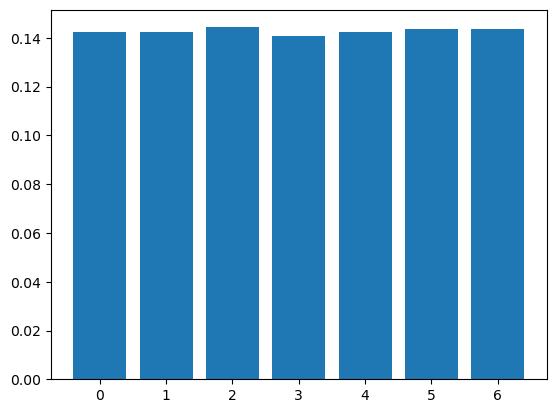

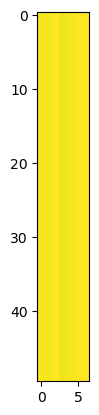

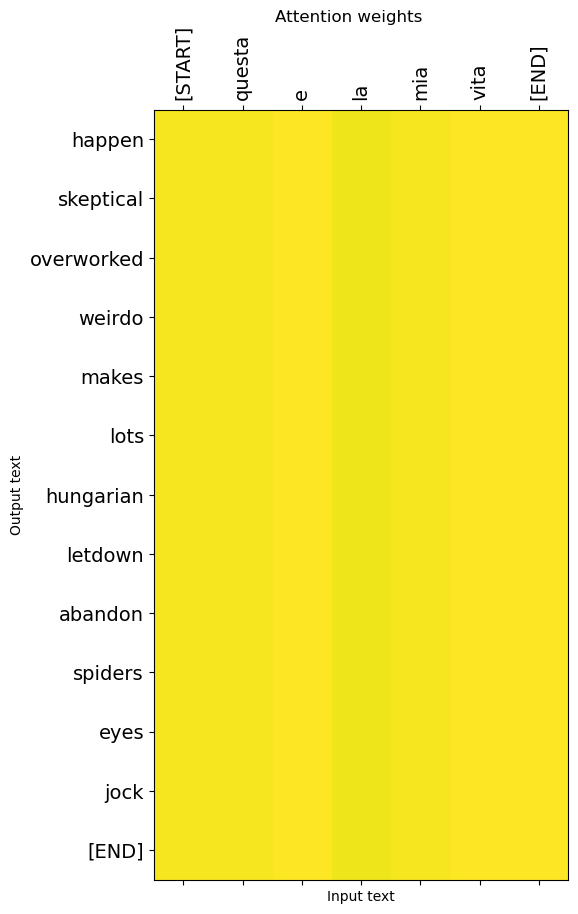

In [69]:
input_text = tf.constant(['Tom sembra rilassato.',
                          'questa è la mia vita',
                          'Lui vorrebbe cucinare.'])

# Translate the input_text using the translate method of translator
### START CODE HERE ###
result, attention = translator.translate(input_text)
### END CODE HERE ###

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

a = attention[1]

print(np.sum(a, axis=-1))
plt.figure()
_ = plt.bar(range(len(a[0, :])), a[0, :])
plt.figure()
plt.imshow(np.array(a), vmin=0.0)

i = 1
plot_attention(attention[i], input_text[i], result[i])

You just created a neural machine translation model with attention, congratulations! If it is good enough you can also use it instead of Google translate :) If you want to increase the performance you can try to implement a [Transformer model](https://www.tensorflow.org/text/tutorials/transformer).

**This was also the last HDA lab...we hope you enjoyed the laboratory sessions and you understood better the different learning strategies by implementing them in practice to solve human-related problems. Thank you for attending the labs and the best of luck for your future! :)**

**Francesca and Silvia**